In [426]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from textwrap import wrap

%matplotlib inline

In [427]:
df = pd.read_csv("../amz_uk_price_prediction_dataset.csv")

In [428]:
print(df.shape)
df.head()

(2443651, 9)


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*


In [429]:
crosstab_result = pd.crosstab(index=df['category'], columns=df['isBestSeller']).sort_values(by=True, ascending=False)

display(crosstab_result)

crosstab_proportions = crosstab_result.apply(lambda x: ((x/x.sum() * 100)
                    ).round(2), axis=1
                    ).sort_values(by=True, ascending=False
                    ).head(10)

display(crosstab_proportions)


# crosstab_result = pd.crosstab(index=df['category'], columns=df['isBestSeller']).sort_values(by=True, ascending=False)
# display(crosstab_result)
# crosstab_proportions = crosstab_result.div(crosstab_result.sum(axis=1), axis=0).sort_values(by=True, ascending=False).head(10)
# display(crosstab_proportions)


isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306
...,...,...
Downhill Ski Boots,1284,0
Digital Frames,774,0
Motorbike Chassis,107,0


isBestSeller,False,True
category,,
Grocery,94.19,5.81
Health & Personal Care,94.23,5.77
Smart Home Security & Lighting,94.23,5.77
Mobile Phone Accessories,95.75,4.25
Power & Hand Tools,96.47,3.53
"Billiard, Snooker & Pool",96.79,3.21
Pet Supplies,96.98,3.02
Home Brewing & Wine Making,97.15,2.85
Mirrors,97.20,2.80




2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.


In [430]:
from scipy.stats import chi2_contingency # type: ignore

chi2_statistic, chi2_p_value, _, expected_freq = chi2_contingency(crosstab_result)
chi2_statistic, chi2_p_value

(36540.202700613874, 0.0)

In [431]:
df_expected = pd.DataFrame(expected_freq, columns=df['isBestSeller'].unique(), index=crosstab_result.index)
df_expected[True].sort_values(ascending=False)

category
Sports & Outdoors                         2730.911534
Beauty                                      63.065372
Handmade Clothing, Shoes & Accessories      62.794327
Bath & Body                                 62.346939
Birthday Gifts                              61.974660
                                             ...     
Plugs                                        0.349420
Motorbike Chassis                            0.349420
Alexa Built-In Devices                       0.349420
Smart Home Security & Lighting               0.339623
Smart Speakers                               0.176343
Name: True, Length: 296, dtype: float64

In [432]:
from scipy.stats.contingency import association # type: ignore

# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_result, method="cramer")

0.12228294397605641


3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.


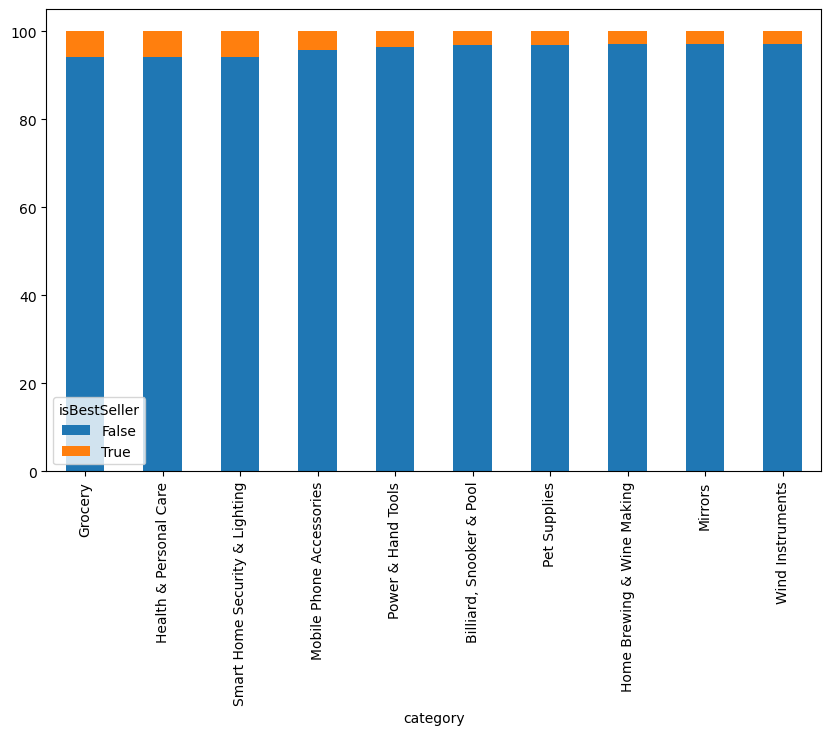

In [433]:
# display(crosstab_proportions)

# sns.countplot(data=crosstab_proportions, x='category', hue=True, legend=False, stat="proportion")
# plt.xticks(rotation=45, ha='right')
# plt.show()

top_10 = crosstab_proportions.head(10).index
crosstab_top_10 = crosstab_proportions.loc[top_10]
crosstab_top_10.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.show()

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*


In [434]:
# count = df.groupby("category").agg("count").sort_values(by="title", ascending=False)
# display(count)

def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    return outliers

outliers = tukeys_test_outliers(df["price"])

display(outliers.values)

prices_to_filter = outliers.values

df_no_outliers = df[~df['price'].isin(prices_to_filter)]

df_no_outliers["price"].max()

array([139.  , 164.99, 149.99, ..., 108.77, 166.99, 158.99])

99.99


1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.


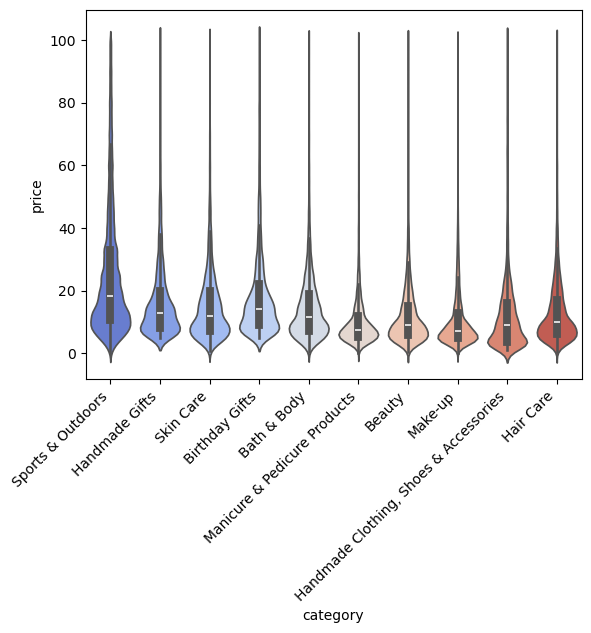

In [435]:
df_count = df_no_outliers.groupby("category").agg("count").sort_values(by="uid", ascending=False).reset_index().head(10)
# display(df_count)

list_to_filter = df_count["category"].values
# display(list_to_filter)

df_filtered = df_no_outliers[df_no_outliers['category'].isin(list_to_filter)]
# display(df_filtered["price"].max())

# Plotting a violin plot to visualize the distribution of 'SalePrice' for each 'MSZoning' category, using the "coolwarm" color palette
sns.violinplot(data=df_filtered, x="category", y='price', palette="coolwarm", hue='category', legend=False)
plt.xticks(rotation=45, ha='right')
plt.show()

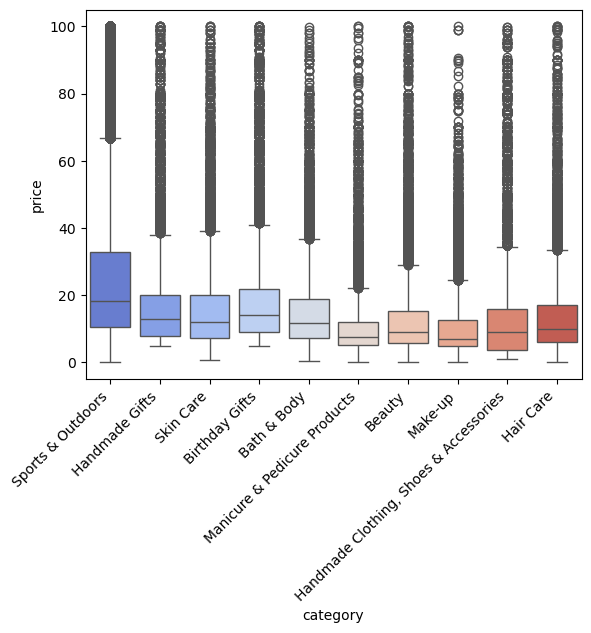

In [436]:
sns.boxplot(data=df_filtered, x='category', y='price', palette="coolwarm", hue='category', legend=False)
plt.xticks(rotation=45, ha='right')
plt.show()


2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.


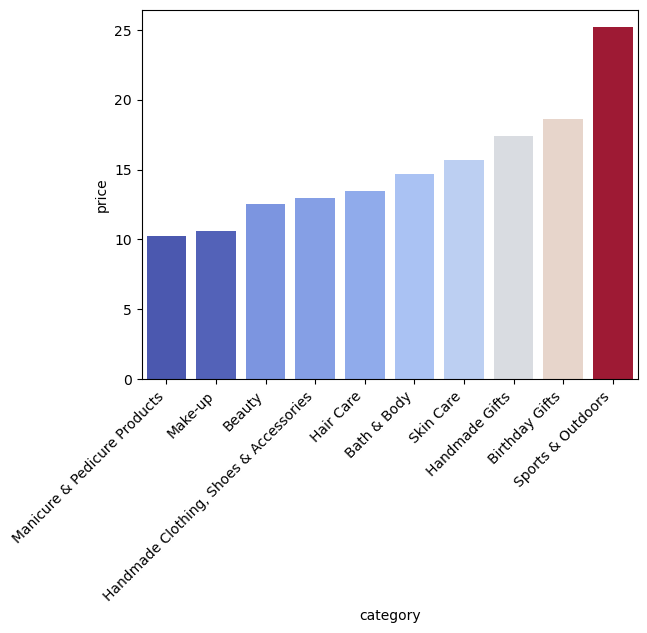

In [437]:
df_price_avg = df_filtered.groupby("category").agg({"price": "mean"}).sort_values(by="price")

sns.barplot(data=df_price_avg, x='category', y='price', palette="coolwarm", hue='price', legend=False)
plt.xticks(rotation=45, ha='right')
plt.show()


3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.


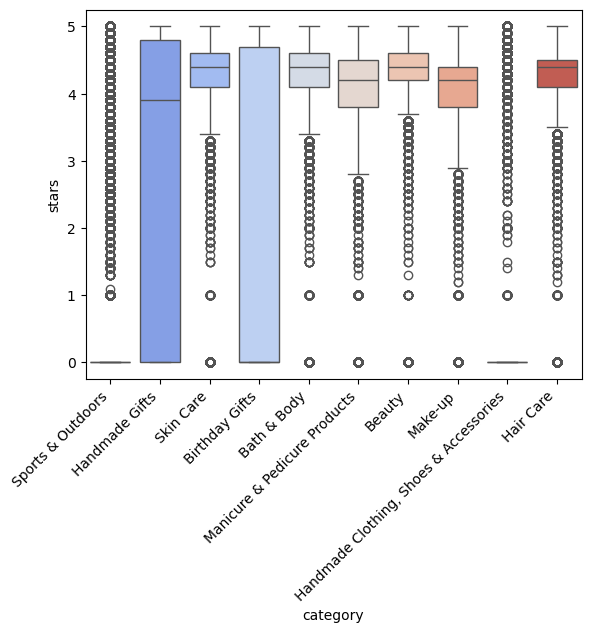

In [438]:
df_filtered

sns.boxplot(data=df_filtered, x='category', y='stars', palette="coolwarm", hue='category', legend=False)
plt.xticks(rotation=45, ha='right')
plt.show()

### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?

In [439]:
# Calculating the Pearson correlation coefficient between 'price' and 'stars' columns
correlation = df['price'].corr(df['stars'])
correlation

-0.12490673262148386

In [440]:


# Calculating the Spearman rank correlation between 'price' and 'stars'
correlation = df['price'].corr(df['stars'], method='spearman')
correlation

-0.13316425462433876

	
2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 


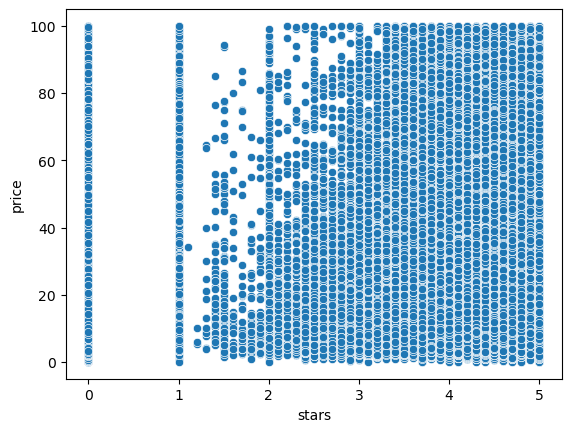

In [441]:
# Plotting a scatter plot to visualize the relationship between 'rating' and 'price'
sns.scatterplot(data=df_filtered, x='stars', y='price')
plt.show()

In [442]:
# Removing the "Id" column from the dataframe
df.drop("uid", inplace=True, axis=1)

potential_categorical_from_numerical = df.select_dtypes("number").loc[:, df.select_dtypes("number").nunique() < 20]

# Adjusting the numerical dataframe by removing the moved columns
df_numerical = df.select_dtypes("number").drop(columns=potential_categorical_from_numerical.columns)

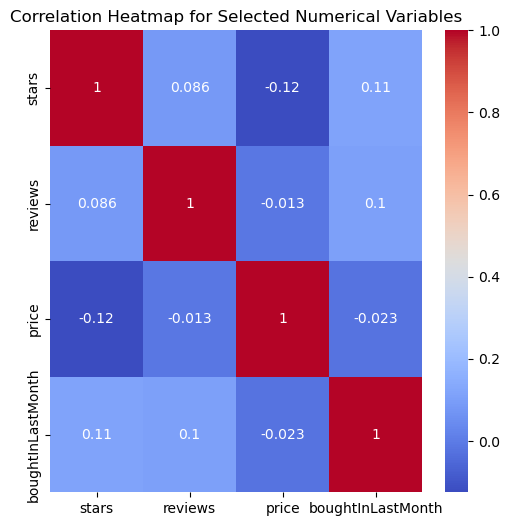

In [443]:
correlation_matrix = df_numerical.corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(6, 6))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()